# Comparison of the performances between model types

to run the notebook, you must: create working/processed/ directory in the submissions/ folder and put all the processed data in it (made at the beginning of the train, or also available in the kaggle_dataset hugorbrt/nlplsv3)

## Import data

In [1]:
import torch
from torch.utils.data import DataLoader, Dataset
from typing import List
import os
import os.path as osp
import torch
from torch_geometric.data import Dataset 
from torch_geometric.data import Data
from torch.utils.data import Dataset as TorchDataset
from transformers import AutoTokenizer
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

class GraphTextDataset(Dataset):
    def __init__(self, root, gt, split, tokenizer=None, transform=None, pre_transform=None):
        self.root = root
        self.gt = gt
        self.split = split
        self.tokenizer = tokenizer
        self.description = pd.read_csv(os.path.join(self.root, split+'.tsv'), sep='\t', header=None)   
        self.description = self.description.set_index(0).to_dict()
        self.cids = list(self.description[1].keys())
        
        self.idx_to_cid = {}
        i = 0
        for cid in self.cids:
            self.idx_to_cid[i] = cid
            i += 1
        super(GraphTextDataset, self).__init__(root, transform, pre_transform)

    @property
    def raw_file_names(self):
        return [str(cid) + ".graph" for cid in self.cids]

    @property
    def processed_file_names(self):
        return ['data_{}.pt'.format(cid) for cid in self.cids]
    
    @property
    def raw_dir(self) -> str:
        return osp.join(self.root, 'raw')

    @property
    def processed_dir(self) -> str:
        return osp.join(self.root, 'processed/', self.split)

    def download(self):
        pass
        
    def process_graph(self, raw_path):
      edge_index  = []
      x = []
      with open(raw_path, 'r') as f:
        next(f)
        for line in f: 
          if line != "\n":
            edge = *map(int, line.split()), 
            edge_index.append(edge)
          else:
            break
        next(f)
        for line in f: #get mol2vec features:
          substruct_id = line.strip().split()[-1]
          if substruct_id in self.gt.keys():
            x.append(self.gt[substruct_id])
          else:
            x.append(self.gt['UNK'])
        return torch.LongTensor(edge_index).T, torch.FloatTensor(x)

    def process(self):
        i = 0        
        for raw_path in self.raw_paths:
            cid = int(raw_path.split('/')[-1][:-6])
            text_input = self.tokenizer([self.description[1][cid]],
                                   return_tensors="pt", 
                                   truncation=True, 
                                   max_length=256,
                                   padding="max_length",
                                   add_special_tokens=True,)
            edge_index, x = self.process_graph(raw_path)
            data = Data(x=x, edge_index=edge_index, input_ids=text_input['input_ids'], attention_mask=text_input['attention_mask'])

            torch.save(data, osp.join(self.processed_dir, 'data_{}.pt'.format(cid)))
            i += 1

    def len(self):
        return len(self.processed_file_names)

    def get(self, idx):
        data = torch.load(osp.join(self.processed_dir, 'data_{}.pt'.format(self.idx_to_cid[idx])))
        return data

    def get_cid(self, cid):
        data = torch.load(osp.join(self.processed_dir, 'data_{}.pt'.format(cid)))
        return data
    
    
class GraphDataset(Dataset):
    def __init__(self, root, gt, split, transform=None, pre_transform=None):
        self.root = root
        self.gt = gt
        self.split = split
        self.description = pd.read_csv(os.path.join(self.root, split+'.txt'), sep='\t', header=None)
        self.cids = self.description[0].tolist()
        
        self.idx_to_cid = {}
        i = 0
        for cid in self.cids:
            self.idx_to_cid[i] = cid
            i += 1
        super(GraphDataset, self).__init__(root, transform, pre_transform)

    @property
    def raw_file_names(self):
        return [str(cid) + ".graph" for cid in self.cids]

    @property
    def processed_file_names(self):
        return ['data_{}.pt'.format(cid) for cid in self.cids]
    
    @property
    def raw_dir(self) -> str:
        return osp.join(self.root, 'raw')

    @property
    def processed_dir(self) -> str:
        return osp.join(self.root, 'processed/', self.split)

    def download(self):
        pass
        
    def process_graph(self, raw_path):
      edge_index  = []
      x = []
      with open(raw_path, 'r') as f:
        next(f)
        for line in f: 
          if line != "\n":
            edge = *map(int, line.split()), 
            edge_index.append(edge)
          else:
            break
        next(f)
        for line in f:
          substruct_id = line.strip().split()[-1]
          if substruct_id in self.gt.keys():
            x.append(self.gt[substruct_id])
          else:
            x.append(self.gt['UNK'])
        return torch.LongTensor(edge_index).T, torch.FloatTensor(x)

    def process(self):
        i = 0        
        for raw_path in self.raw_paths:
            cid = int(raw_path.split('/')[-1][:-6])
            edge_index, x = self.process_graph(raw_path)
            data = Data(x=x, edge_index=edge_index)
            torch.save(data, osp.join(self.processed_dir, 'data_{}.pt'.format(cid)))
            i += 1

    def len(self):
        return len(self.processed_file_names)

    def get(self, idx):
        data = torch.load(osp.join(self.processed_dir, 'data_{}.pt'.format(self.idx_to_cid[idx])))
        return data

    def get_cid(self, cid):
        data = torch.load(osp.join(self.processed_dir, 'data_{}.pt'.format(cid)))
        return data
    
    def get_idx_to_cid(self):
        return self.idx_to_cid
    
class TextDataset(TorchDataset):
    def __init__(self, file_path, tokenizer, max_length=256):
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.sentences = self.load_sentences(file_path)

    def load_sentences(self, file_path):
        with open(file_path, 'r', encoding='utf-8') as file:
            lines = file.readlines()
        return [line.strip() for line in lines]

    def __len__(self):
        return len(self.sentences)

    def __getitem__(self, idx):
        sentence = self.sentences[idx]

        encoding = self.tokenizer.encode_plus(
            sentence,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].squeeze(),
            'attention_mask': encoding['attention_mask'].squeeze()
        }
tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')
gt = np.load("working/token_embedding_dict.npy", allow_pickle=True)[()]
val_dataset = GraphTextDataset(root='working', gt=gt, split='val', tokenizer=tokenizer)

/Users/hugorobert/Library/Python/3.11/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/var/folders/ds/pk0f0vys53j34_2xjrlcslx80000gn/T/ipykernel_5322/910110314.py:12: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
def get_info(dataset, sample_id):
    """return statistics about a sample of the dataset: number of substructures, number of edges"""
    data = dataset.get(sample_id)
    return data.x.shape[0], (data.edge_index.shape[1]if len(data.edge_index.shape) == 2 else 0)

statistics = [] # size [nb_samples, 2] contains for each sample info on nb of node and edges
for i in range(len(val_dataset)):
    statistics.append(get_info(val_dataset, i))

In [3]:
# We will takes results from 2 MLP models and 1 GAT model
df_mlp = pd.read_csv('MLP_valid_submission.csv').drop('ID', axis=1)
df_mlp = (df_mlp - df_mlp.min()) / (df_mlp.max() - df_mlp.min())

df_mlp2 = pd.read_csv('MLP_valid_submission_2.csv').drop('ID', axis=1)
df_mlp2 = (df_mlp2 - df_mlp2.min()) / (df_mlp2.max() - df_mlp2.min())

df_gat = pd.read_csv('GAT_valid_submission.csv').drop('ID', axis=1)
df_gat = (df_gat - df_gat.min()) / (df_gat.max() - df_gat.min())

# We will test to merge results of two different models (MLP+GAT) and 2 same models (MLP+MLP)
df_merged = (df_mlp+df_gat)/2
df_2mlp = (df_mlp+df_mlp2)/2

In [4]:
df = pd.DataFrame()
df['nb_nodes'] = [x[0] for x in statistics]
df['nb_edges'] = [x[1] for x in statistics]
df['rank_mlp'] = df_mlp.rank(axis=1, method='min', ascending=False).apply(lambda x: x.iloc[int(x.name)], axis=1).astype(int)
df['accuracy_mlp'] = np.where(df['rank_mlp'] < 10, 1 / df['rank_mlp'], 0)
df['rank_mlp2'] = df_mlp2.rank(axis=1, method='min', ascending=False).apply(lambda x: x.iloc[int(x.name)], axis=1).astype(int)
df['accuracy_mlp2'] = np.where(df['rank_mlp2'] < 10, 1 / df['rank_mlp2'], 0)
df['rank_gat'] = df_gat.rank(axis=1, method='min', ascending=False).apply(lambda x: x.iloc[int(x.name)], axis=1).astype(int)
df['accuracy_gat'] = np.where(df['rank_gat'] < 10, 1 / df['rank_gat'], 0)
df['rank_merged'] = df_merged.rank(axis=1, method='min', ascending=False).apply(lambda x: x.iloc[int(x.name)], axis=1).astype(int)
df['accuracy_merged'] = np.where(df['rank_merged'] < 10, 1 / df['rank_merged'], 0)
df['rank_2mlp'] = df_2mlp.rank(axis=1, method='min', ascending=False).apply(lambda x: x.iloc[int(x.name)], axis=1).astype(int)
df['accuracy_2mlp'] = np.where(df['rank_2mlp'] < 10, 1 / df['rank_2mlp'], 0)
df.head()

,nb_nodes,nb_edges,rank_mlp,accuracy_mlp,rank_mlp2,accuracy_mlp2,rank_gat,accuracy_gat,rank_merged,accuracy_merged,rank_2mlp,accuracy_2mlp
0,21,46,1,1.0,1,1.0,1,1.00,1,1.0,1,1.0
1,56,118,1,1.0,1,1.0,1,1.00,1,1.0,1,1.0
2,30,66,1,1.0,1,1.0,1,1.00,1,1.0,1,1.0
3,7,12,2,0.5,1,1.0,1,1.00,1,1.0,1,1.0
4,21,44,1,1.0,1,1.0,4,0.25,1,1.0,1,1.0


## Analysis on the statistics of the samples

We can observe that merging GAT and MLP results allows us to decrease the number of our errors AND the rank of the misclassified samples!

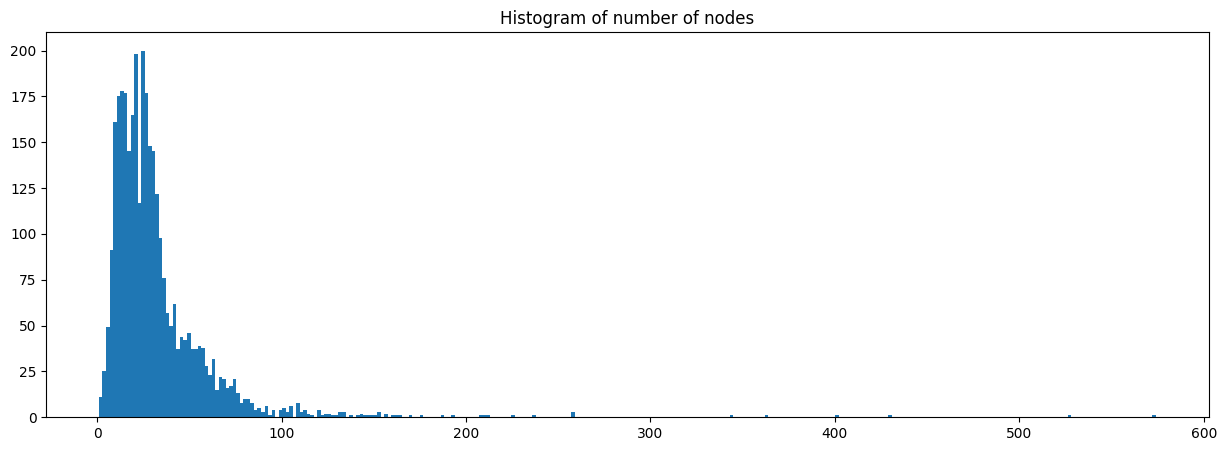

proportion of samples with more than 100 nodes: 2.51438957891548 %


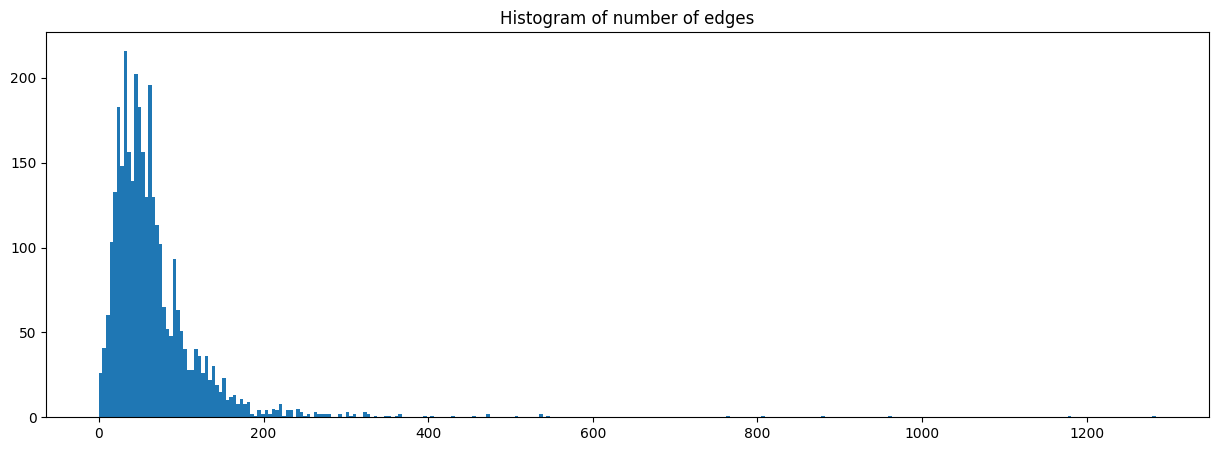

proportion of samples with more than 200 edges: 2.696152681005756 %


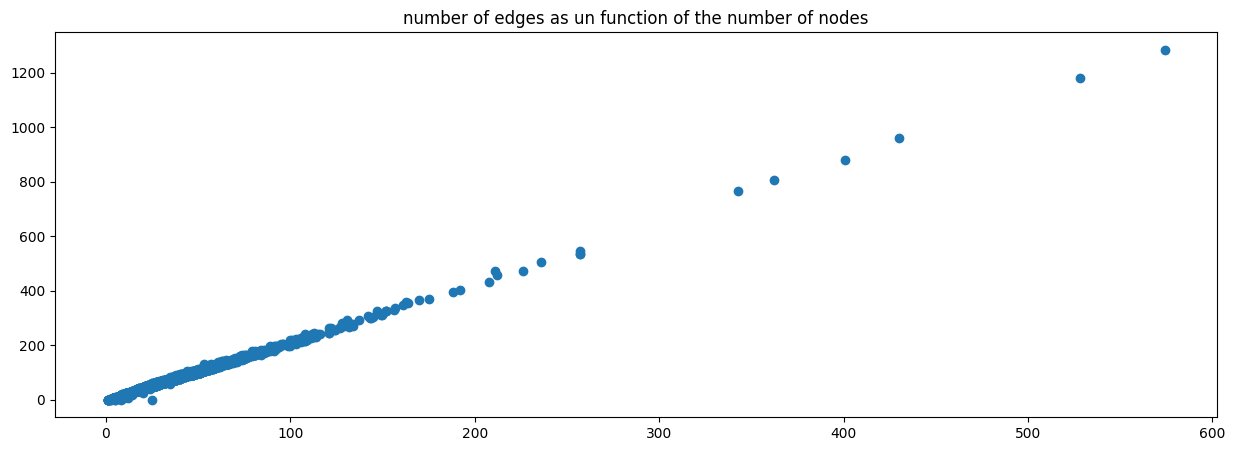

correlation between number of nodes and number of edges: 0.9980577434458447


In [5]:
plt.figure(figsize=(15, 5))
plt.hist(df['nb_nodes'], bins=300)
plt.title('Histogram of number of nodes')
plt.show()
print(f"proportion of samples with more than 100 nodes: {((df['nb_nodes']>100).sum()*100 / len(df))} %")

plt.figure(figsize=(15, 5))
plt.hist(df['nb_edges'], bins=300)
plt.title('Histogram of number of edges')
plt.show()
print(f"proportion of samples with more than 200 edges: {((df['nb_edges']>200).sum()*100 / len(df))} %")

plt.figure(figsize=(15, 5))
plt.scatter(df['nb_nodes'], df['nb_edges'])
plt.title('number of edges as un function of the number of nodes')
plt.show()
print(f"correlation between number of nodes and number of edges: {df['nb_nodes'].corr(df['nb_edges'])}")

We can observe that there is an high correlation between number of edges and number of nodes (it seems that the number of edges is about 2 times the number of nodes)

## Analysis on the behaviour of our models

### Impact of merging results

(Quick results for this section: merging improves overall predictivity, whether MLP+MLP or MLP+GAT.)

#### Merging between same type of models (MLP+MLP)

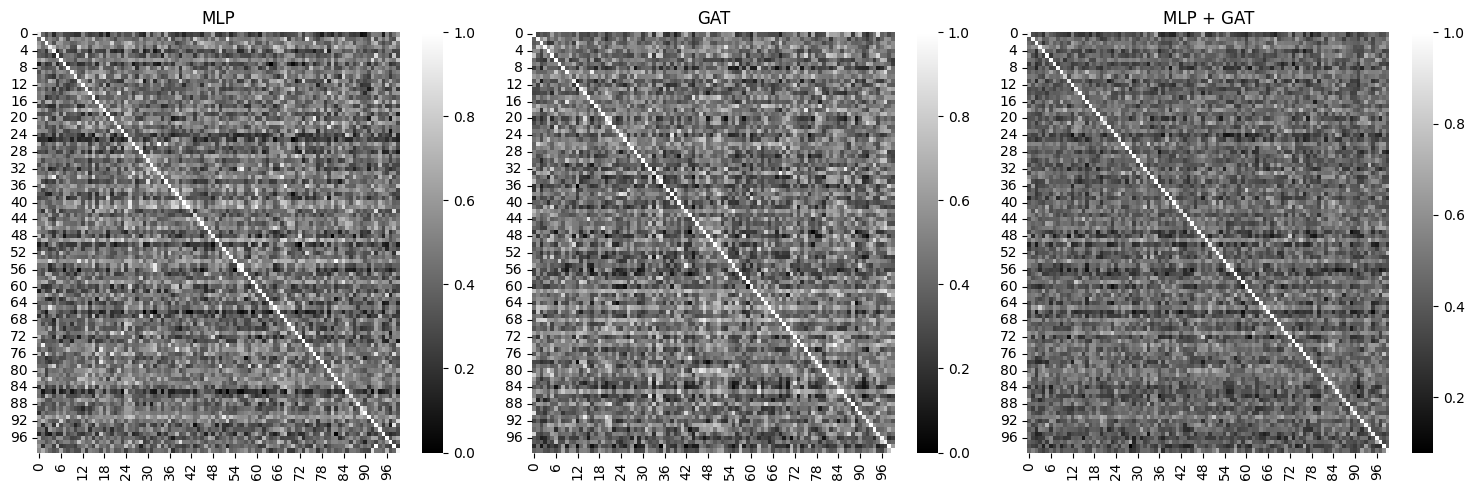

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
sns.heatmap(df_mlp.iloc[:100,:100], cmap='grey', ax=axs[0])
axs[0].set_title('MLP')
sns.heatmap(df_mlp2.iloc[:100,:100], cmap='grey', ax=axs[1])
axs[1].set_title('GAT')
sns.heatmap(df_2mlp.iloc[:100,:100], cmap='grey', ax=axs[2])
axs[2].set_title('MLP + GAT')
plt.tight_layout()
plt.show()

The contrast on MLP + MLP is enhanced, which leads us to believe that the results will be better

In [7]:
print(f"number of error in mlp model: {(df['rank_mlp']>1).sum()}")
print(f"\tmean rank of the errors: {df[df['rank_mlp']>1]['rank_mlp'].mean()}")

print(f"number of error in mlp2 model: {(df['rank_mlp2']>1).sum()}")
print(f"\tmean rank of the errors: {df[df['rank_mlp2']>1]['rank_mlp2'].mean()}")

print(f"number of error in merged model: {(df['rank_2mlp']>1).sum()}")
print(f"\tmean rank of the errors: {df[df['rank_2mlp']>1]['rank_2mlp'].mean()}")

number of error in mlp model: 563
	mean rank of the errors: 13.27886323268206
number of error in mlp2 model: 477
	mean rank of the errors: 14.884696016771489
number of error in merged model: 12
	mean rank of the errors: 3.25


In [8]:
df_temp = df[df['rank_2mlp']==1]
print(f"percentage of samples where classification of merged is correct but not mlp or mlp2: {((df_temp['rank_mlp']>1) | (df_temp['rank_mlp2']>1)).sum() *100/ len(df)}%")

df_temp = df[df['rank_2mlp']>1]
print(f"percentage of samples where classification of mlp or mlp2 is correct but not merged model: {((df_temp['rank_mlp']==1) | (df_temp['rank_mlp2']==1)).sum() *100/ len(df)}%")

percentage of samples where classification of merged is correct but not mlp or mlp2: 28.900333232353834%
percentage of samples where classification of mlp or mlp2 is correct but not merged model: 0.27264465313541353%


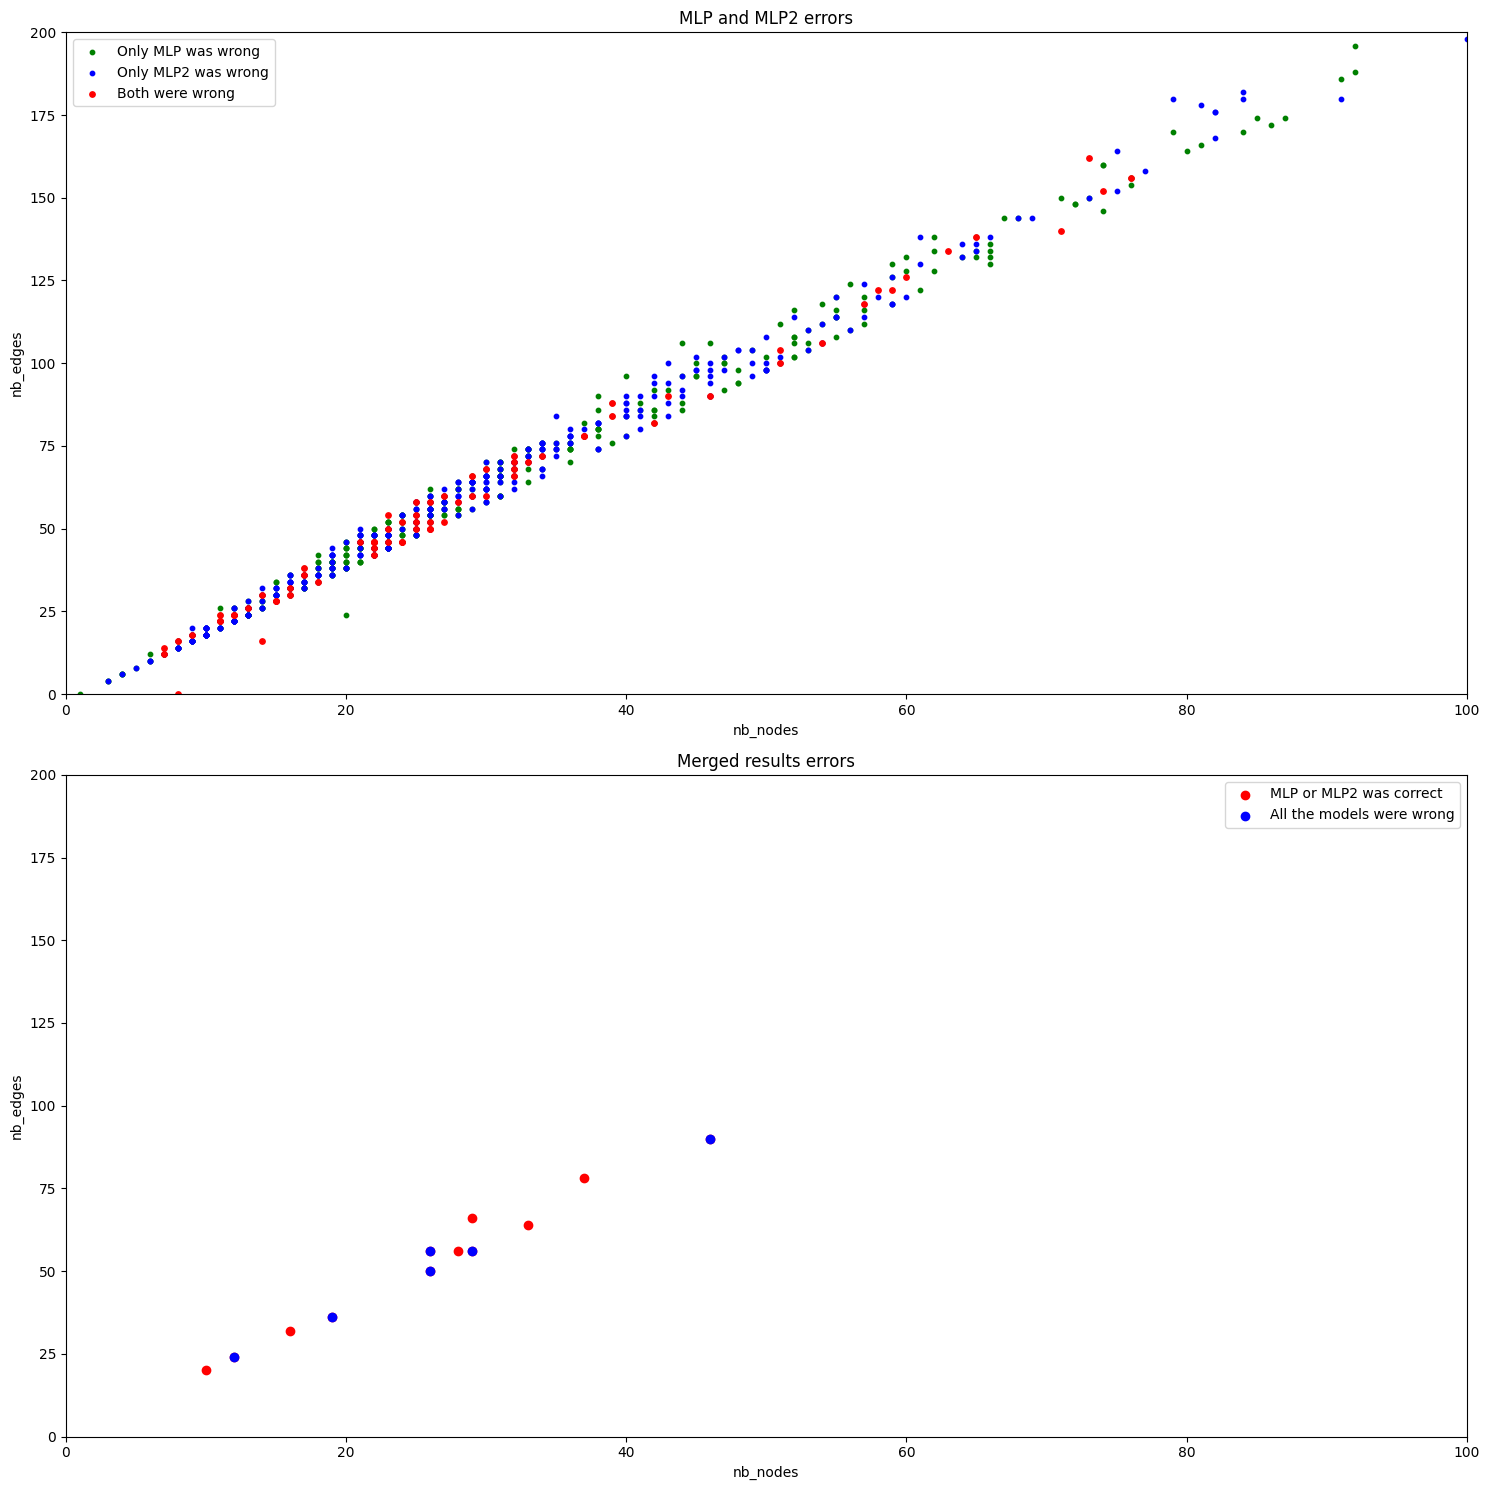

In [9]:
# plot nb_nodes and nb_edges where the model is wrong
fig, axs = plt.subplots(2, 1, figsize=(15, 15))

df_temp = df[(df['rank_mlp']>1) & (df['rank_mlp2']==1)]
axs[0].scatter(df_temp['nb_nodes'], df_temp['nb_edges'], color='green', label="Only MLP was wrong", s=10)
df_temp = df[(df['rank_mlp']==1) & (df['rank_mlp2']>1)]
axs[0].scatter(df_temp['nb_nodes'], df_temp['nb_edges'], color='blue', label="Only MLP2 was wrong", s=10)
df_temp = df[(df['rank_mlp']>1) & (df['rank_mlp2']>1)]
axs[0].scatter(df_temp['nb_nodes'], df_temp['nb_edges'], color='red', label="Both were wrong", s=15)
axs[0].set_xlim(0, 100)
axs[0].set_xlabel('nb_nodes')
axs[0].set_ylim(0, 200)
axs[0].set_ylabel('nb_edges')
axs[0].legend()
axs[0].set_title('MLP and MLP2 errors')

df_temp = df[(df['rank_2mlp']>1)]
axs[1].scatter(df_temp['nb_nodes'], df_temp['nb_edges'], color='red', label="MLP or MLP2 was correct")
df_temp = df[(df['rank_2mlp']>1) & (df['rank_mlp2']>1) & (df['rank_mlp2']>1)]
axs[1].scatter(df_temp['nb_nodes'], df_temp['nb_edges'], color='blue', label="All the models were wrong")
axs[1].set_xlim(0, 100)
axs[1].set_xlabel('nb_nodes')
axs[1].set_ylim(0, 200)
axs[1].set_ylabel('nb_edges')
axs[1].legend()
axs[1].set_title('Merged results errors')

plt.tight_layout()
plt.show()

It seems that when the merge result is wrong, there is a 50% chance that one of the models was right.

#### Merging between different types of models (MLP+GAT)

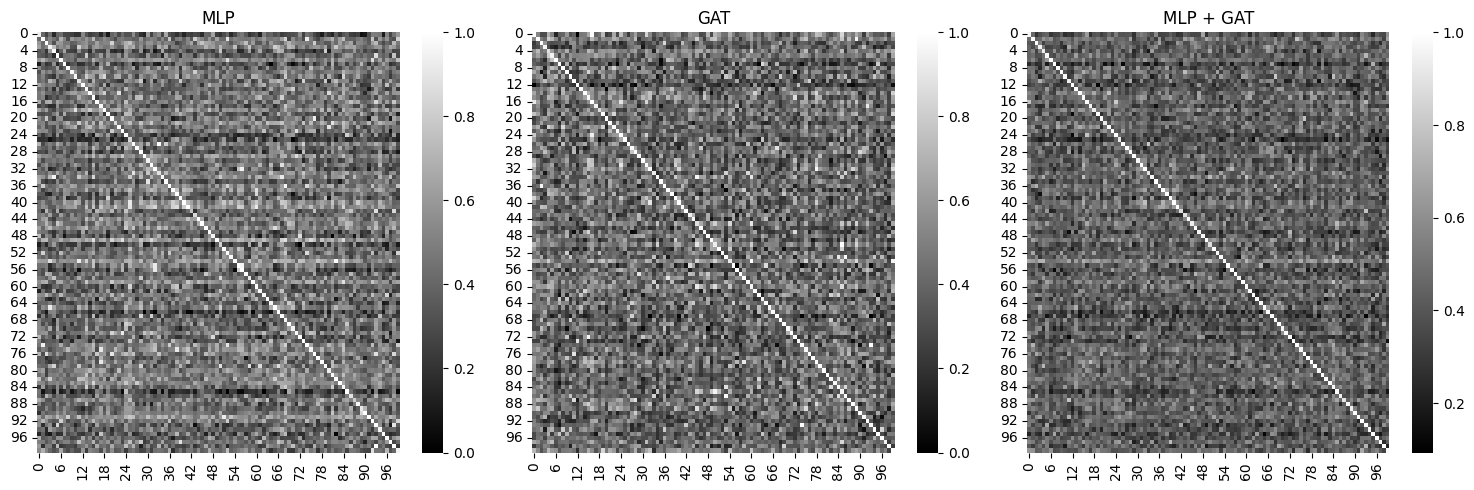

In [10]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
sns.heatmap(df_mlp.iloc[:100,:100], cmap='grey', ax=axs[0])
axs[0].set_title('MLP')
sns.heatmap(df_gat.iloc[:100,:100], cmap='grey', ax=axs[1])
axs[1].set_title('GAT')
sns.heatmap(df_merged.iloc[:100,:100], cmap='grey', ax=axs[2])
axs[2].set_title('MLP + GAT')
plt.tight_layout()
plt.show()

The contrast on MLP + GAT is enhanced, which leads us to believe that the results will be better

In [11]:
print(f"number of error in mlp model: {(df['rank_mlp']>1).sum()}")
print(f"\tmean rank of the errors: {df[df['rank_mlp']>1]['rank_mlp'].mean()}")

print(f"number of error in gat model: {(df['rank_gat']>1).sum()}")
print(f"\tmean rank of the errors: {df[df['rank_gat']>1]['rank_gat'].mean()}")

print(f"number of error in merged model: {(df['rank_merged']>1).sum()}")
print(f"\tmean rank of the errors: {df[df['rank_merged']>1]['rank_merged'].mean()}")

number of error in mlp model: 563
	mean rank of the errors: 13.27886323268206
number of error in gat model: 552
	mean rank of the errors: 7.405797101449275
number of error in merged model: 9
	mean rank of the errors: 2.4444444444444446


We can see that merging results of the two models decrease the number of errors, and the mean rank of the missclassified samples

In [12]:
df_temp = df[df['rank_merged']==1]
print(f"proportion of samples where classification of merged is correct but not mlp or gat: {((df_temp['rank_mlp']>1) | (df_temp['rank_gat']>1)).sum() *100/ len(df)}%")

df_temp = df[df['rank_merged']>1]
print(f"proportion of samples where classification of mlp or gat is correct but not merged model: {((df_temp['rank_mlp']==1) | (df_temp['rank_gat']==1)).sum() *100/ len(df)}%")


proportion of samples where classification of merged is correct but not mlp or gat: 30.475613450469556%
proportion of samples where classification of mlp or gat is correct but not merged model: 0.1514692517418964%


this results shows that merging results allows us to classify correctly 29% of the samples which was missclassified in one of the MLP/GAT models was wellclassified in the merged results

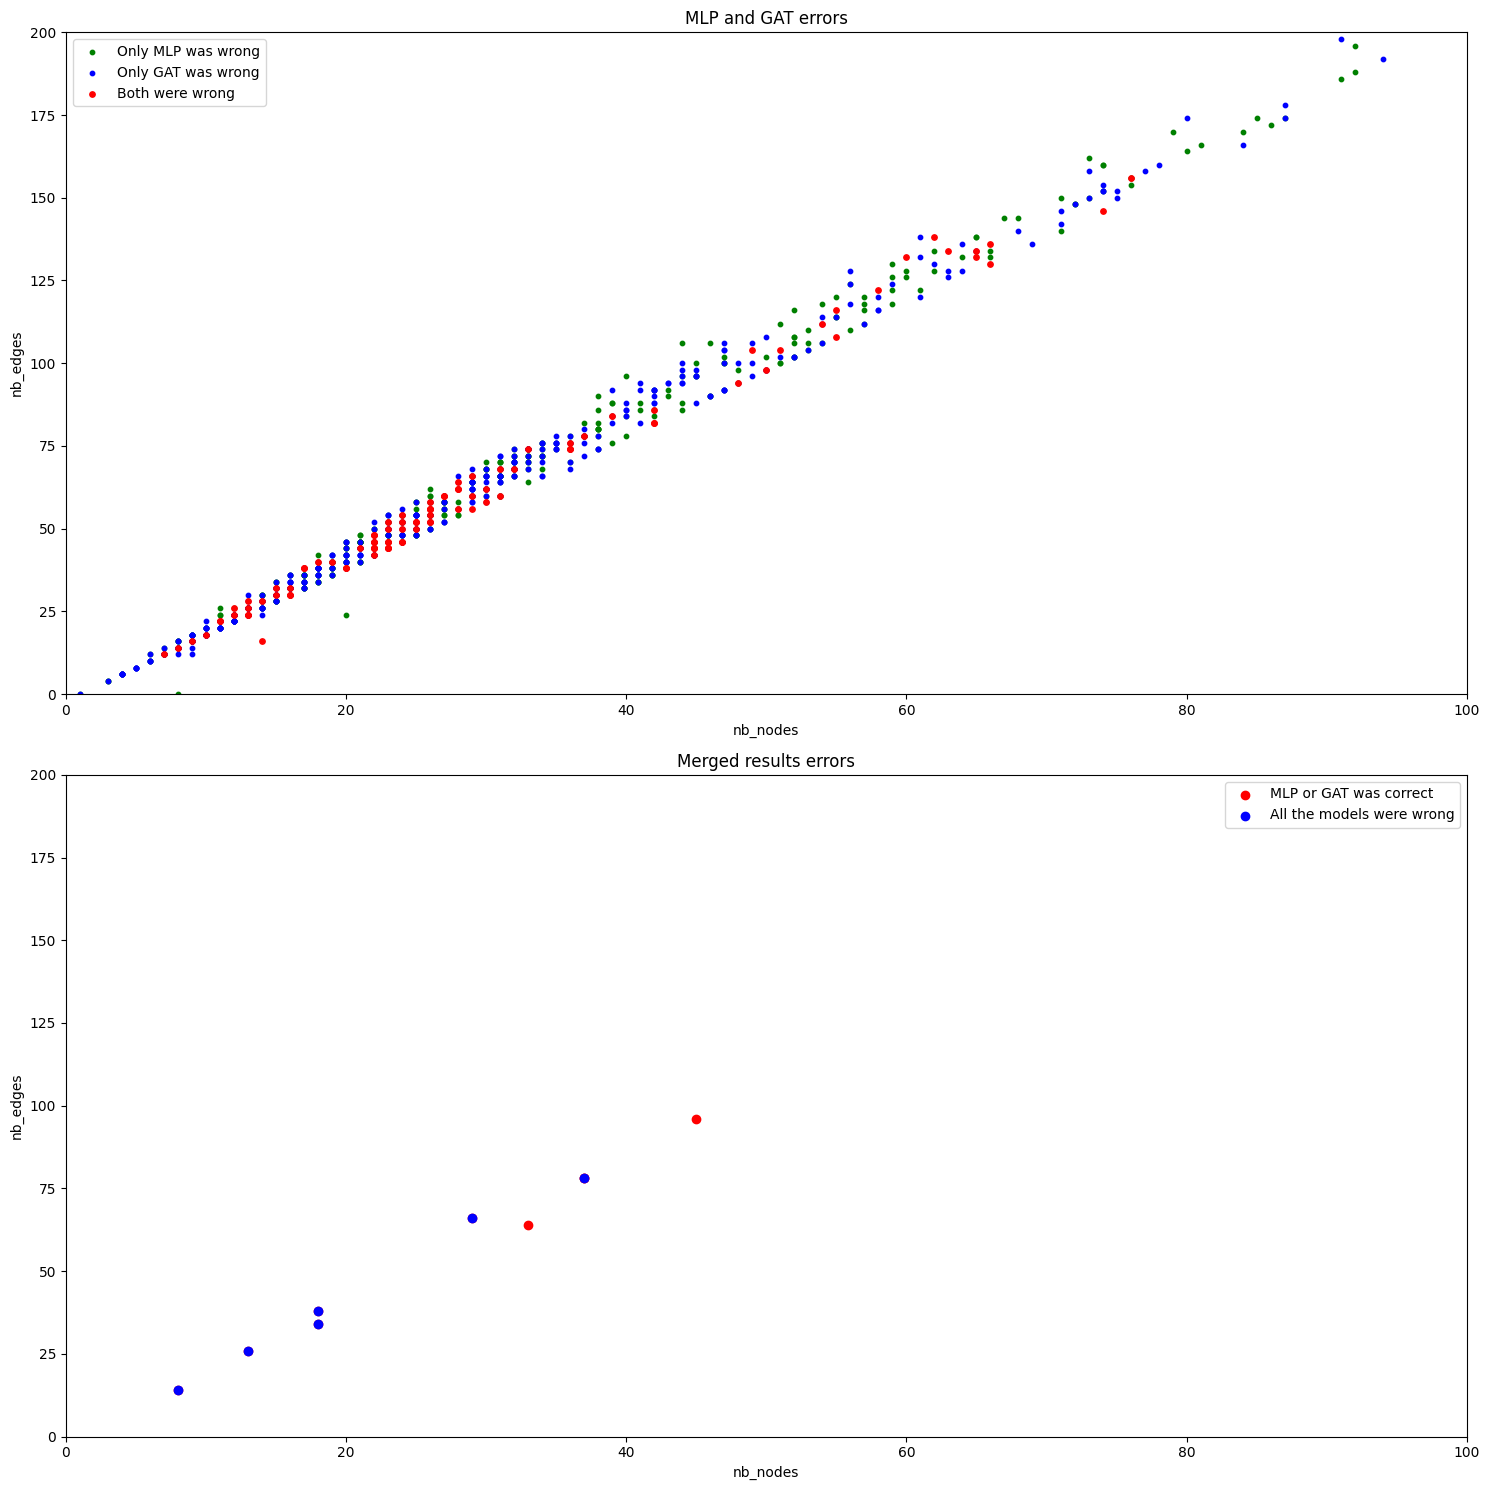

In [13]:
# plot nb_nodes and nb_edges where the model is wrong
fig, axs = plt.subplots(2, 1, figsize=(15, 15))

df_temp = df[(df['rank_mlp']>1) & (df['rank_gat']==1)]
axs[0].scatter(df_temp['nb_nodes'], df_temp['nb_edges'], color='green', label="Only MLP was wrong", s=10)
df_temp = df[(df['rank_mlp']==1) & (df['rank_gat']>1)]
axs[0].scatter(df_temp['nb_nodes'], df_temp['nb_edges'], color='blue', label="Only GAT was wrong", s=10)
df_temp = df[(df['rank_mlp']>1) & (df['rank_gat']>1)]
axs[0].scatter(df_temp['nb_nodes'], df_temp['nb_edges'], color='red', label="Both were wrong", s=15)
axs[0].set_xlim(0, 100)
axs[0].set_xlabel('nb_nodes')
axs[0].set_ylim(0, 200)
axs[0].set_ylabel('nb_edges')
axs[0].legend()
axs[0].set_title('MLP and GAT errors')

df_temp = df[(df['rank_merged']>1)]
axs[1].scatter(df_temp['nb_nodes'], df_temp['nb_edges'], color='red', label="MLP or GAT was correct")
df_temp = df[(df['rank_merged']>1) & (df['rank_gat']>1) & (df['rank_gat']>1)]
axs[1].scatter(df_temp['nb_nodes'], df_temp['nb_edges'], color='blue', label="All the models were wrong")
axs[1].set_xlim(0, 100)
axs[1].set_xlabel('nb_nodes')
axs[1].set_ylim(0, 200)
axs[1].set_ylabel('nb_edges')
axs[1].legend()
axs[1].set_title('Merged results errors')

plt.tight_layout()
plt.show()

we don't have enough data to know if it's common for the merge result to be bad when one of the models was correct

### Correlation between classification and number of nodes/edges

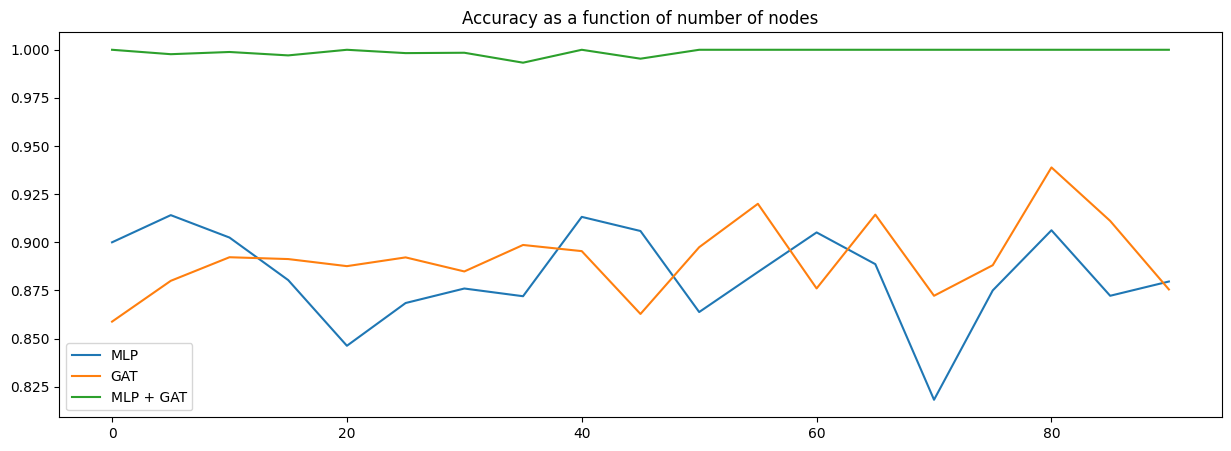

In [14]:
df_temp = df
df_temp['groupping'] = df_temp['nb_nodes'].apply(lambda x: 5*(x//5) if x < 90 else 90)
df_temp = df_temp.groupby('groupping').mean().reset_index()

plt.figure(figsize=(15, 5))
plt.plot(df_temp['groupping'], df_temp['accuracy_mlp'], label='MLP')
plt.plot(df_temp['groupping'], df_temp['accuracy_gat'], label='GAT')
plt.plot(df_temp['groupping'], df_temp['accuracy_merged'], label='MLP + GAT')
plt.title('Accuracy as a function of number of nodes')
plt.legend()
plt.show()

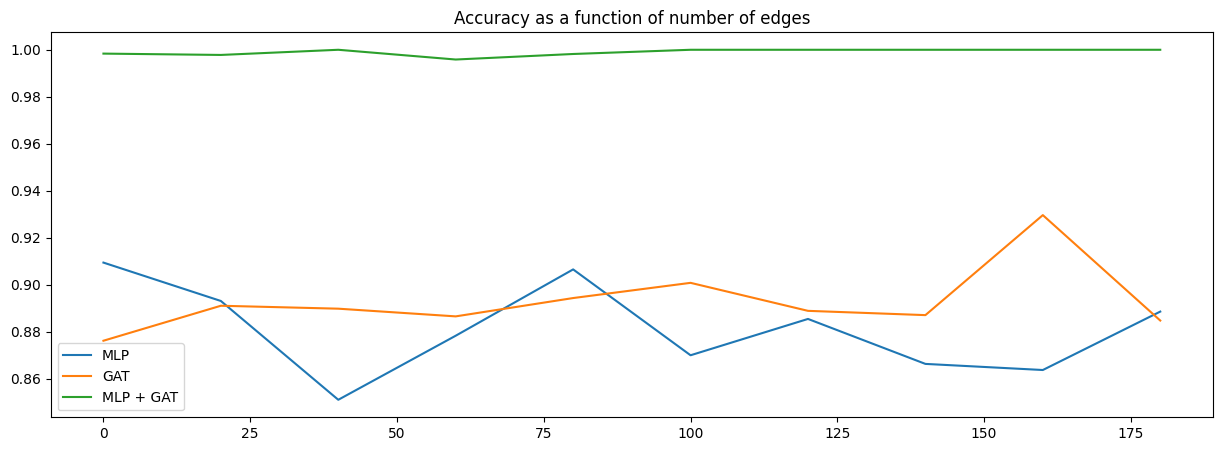

In [15]:
df_temp = df
df_temp['groupping'] = df['nb_edges'].apply(lambda x: 20*(x//20) if x < 180 else 180)
df_temp = df_temp.groupby('groupping').mean().reset_index()
df_temp.head()

plt.figure(figsize=(15, 5))
plt.plot(df_temp['groupping'], df_temp['accuracy_mlp'], label='MLP')
plt.plot(df_temp['groupping'], df_temp['accuracy_gat'], label='GAT')
plt.plot(df_temp['groupping'], df_temp['accuracy_merged'], label='MLP + GAT')
plt.legend()
plt.title('Accuracy as a function of number of edges')
plt.show()

It's difficult to see a 'link' between the qualioty of predictions of a given model according to the number of nodes/edges